In [1]:
!pip -q install diffusers transformers accelerate torch xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

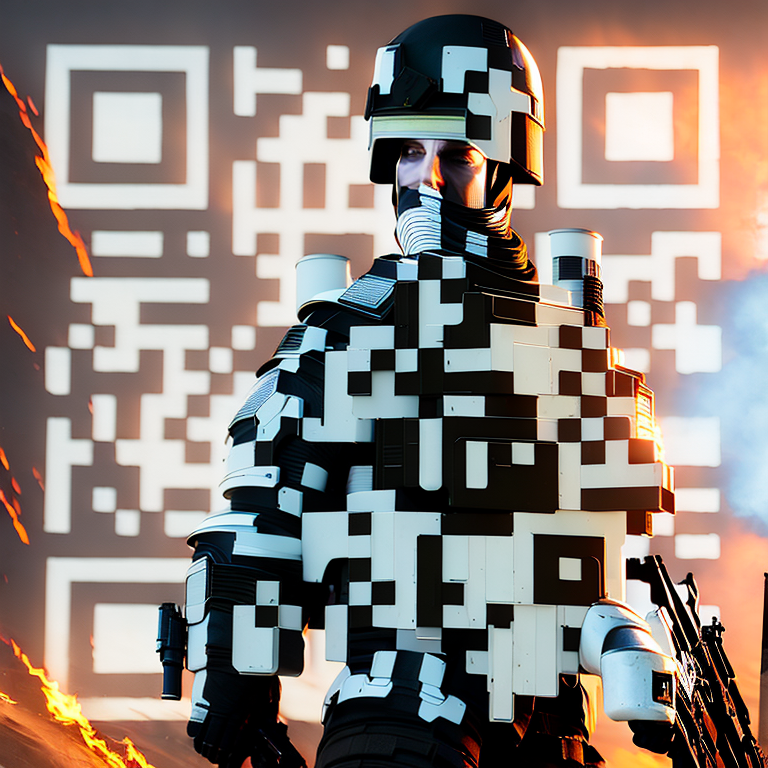

In [1]:
"""
This a Colab that uses the "DionTimmer/controlnet_qrcode-control_v11p_sd21"
control net model from HuggingFace to generate QR Codes based on base images
and text prompts

HuggingFace link to the model
https://huggingface.co/DionTimmer/controlnet_qrcode-control_v11p_sd21

Medium Article describing this Colab in somre mored detail
https://medium.com/@ssmaameri/ai-generated-qr-codes-with-controlnet-huggingface-and-google-colab-a99ffeee2210

Powerpoint showing affects of different guidance_scale,
controlnet_conditioning_scale and strength values in the model
https://docs.google.com/presentation/d/1spTfvtorPxZ1yQTXH_tkKi32WzbusqbtStXyvlJMShk/edit?usp=sharing

"""

import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import base64
from io import BytesIO

controlnet = ControlNetModel.from_pretrained(
    "DionTimmer/controlnet_qrcode-control_v11p_sd21",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

# qr code image
qr_code_image = load_image("/content/deveshqr.png")
qr_code_image = resize_for_condition_image(qr_code_image, 768)

# base image
base_image = load_image("/content/cod.jpg")
base_image = resize_for_condition_image(base_image, 768)


# play with guidance_scale, controlnet_conditioning_scale and strength to vary
# the dominance of the QR Code vs the base image and prompt

# Approximate optimal default value
#   guidance_scale = 20,
#   controlnet_conditioning_scale = 2.0,
#   strength = 0.9

generator = torch.manual_seed(123121231)
image = pipe(
    prompt="call of duty , realistic, 8K, fantasy, action ",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=base_image,
    control_image=qr_code_image,
    width=768,
    height=768,
    guidance_scale=30,  # The higher the values, the sharper the final image is, including the QR Code and base image. Below is an idea of what it looks like when varying the value between 0 and 100, where the middle one is at the near optimum value of 20
    controlnet_conditioning_scale=2.0,  # This tweaks how strong to make the QR image vs the base image. The images below you can see the results when varying the value between 0–5. At low values, the QR code does not come through at all. At high values, all you can see is the QR code. This field seems to have the ability to remove the base image nearly completely.
    generator=generator,
    strength=1.5,  # this also controls how strong the QR code comes through over the base image. At low values the QR code barely comes though. At high values it is much more dominant.
    num_inference_steps=150
)

image.images[0]